In [ ]:
#load the data from website of matlab format, and save locally as a file

In [1]:
import requests
import zipfile
import tempfile
 
 
def get_data():
    url = "http://www.itl.nist.gov/iaui/vip/cs_links/EMNIST/matlab.zip"
    response = requests.get(url)
    return url, response.content
 
 
if __name__ == '__main__':
    url, data = get_data()  # data is byte type
 
    _tmp_file = tempfile.TemporaryFile()  #Create temporary files
    print(_tmp_file)
 
    _tmp_file.write(data)  # write byte data to temporary file
 
    zf = zipfile.ZipFile(_tmp_file, mode='r')
    for names in zf.namelist():
        f = zf.extract(names, 'EMNIST./zip')  #Unzip to the zip directory file
        print(f)
 
    zf.close()

<_io.BufferedRandom name=57>
EMNIST./zip/matlab/emnist-balanced.mat
EMNIST./zip/matlab/emnist-byclass.mat
EMNIST./zip/matlab/emnist-bymerge.mat
EMNIST./zip/matlab/emnist-digits.mat
EMNIST./zip/matlab/emnist-letters.mat
EMNIST./zip/matlab/emnist-mnist.mat


In [ ]:
#load the file

In [2]:
from scipy import io as sio
file = sio.loadmat('./EMNIST./zip/matlab/emnist-byclass.mat')

In [ ]:
#load the data, seperate the data to train set and data set, then reshape

In [3]:
import numpy as np

print(file.keys())
train = file['dataset'][0][0][0]
test = file['dataset'][0][0][1]
data_train = train[0][0][0]
label_train = train[0][0][1].reshape(-1)
data_test = test[0][0][0]
label_test = test[0][0][1].reshape(-1)

mapping = file['dataset'][0][0][2]

print(data_train.shape)
print(label_train.shape)
print(data_test.shape)
print(label_test.shape)

dict_keys(['__header__', '__version__', '__globals__', 'dataset'])
(697932, 784)
(697932,)
(116323, 784)
(116323,)


In [ ]:
#rotate the image by -90 degree and then flip horizontally

In [4]:
data_train = data_train.reshape([-1,28,28])
data_train = np.rot90(data_train, axes=[2,1])
data_train = np.flip(data_train, axis=2)
data_train = data_train.reshape([-1, 28 * 28])
data_test = data_test.reshape([-1,28,28])
data_test = np.rot90(data_test, axes=[2,1])
data_test = np.flip(data_test, axis=2)
data_test= data_test.reshape([-1, 28 * 28])

#randomly shuffle the data, and take 10% of the dataset 
#1/10 for train and test respectively, 69793 train samples and 11632 test samples

train_sample_index = np.random.choice(data_train.shape[0], data_train.shape[0]//10)
data_train = data_train[train_sample_index]
label_train = label_train[train_sample_index]

test_sample_index = np.random.choice(data_test.shape[0], data_test.shape[0]//10)
data_test = data_test[test_sample_index]
label_test = label_test[test_sample_index]

print(data_train.shape)
print(label_train.shape)
print(data_test.shape)
print(label_test.shape)

(69793, 784)
(69793,)
(11632, 784)
(11632,)


In [ ]:
#show the original image in dataset

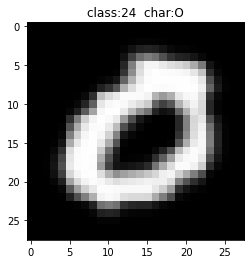

In [5]:
import matplotlib.pyplot as plt
img = data_train[0].reshape([28,28])
plt.imshow(img, cmap=plt.get_cmap('gray'))
plt.title("class:" +  str(label_train[0]) + "  char:" + chr(mapping[label_train[0]][1]))
plt.show()

In [6]:
# Pre-Processing Normaliazation

In [7]:
#all feature data are divided by 255 to scale all image pixels to 0-1.
data_train = data_train/255
data_test = data_test/255

In [8]:
# Pre-Processing PCA

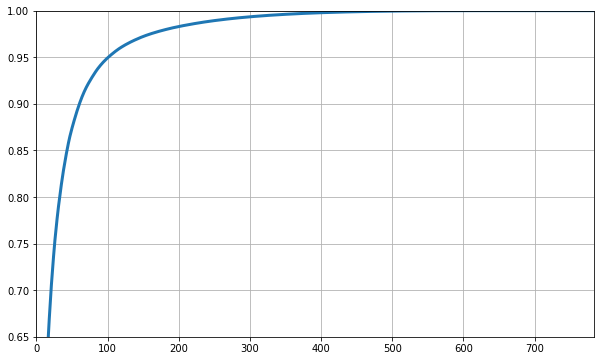

In [9]:
from sklearn.decomposition import PCA

pca = PCA()
#train
pca.fit(data_train)

cumsum = np.cumsum(pca.explained_variance_ratio_)

#show the image of the variance occupied by each dimension
plt.figure(figsize = (10,6) )
plt.plot(cumsum, linewidth = 3)
plt.axis([0,784,0.65,1])
plt.grid(True)
plt.show()

In [10]:
# reduce the dimension 150, because when the dimension is 150, more than 95% of the information is already covered.
pca = PCA(n_components=150)
pca.fit(data_train)


data_train = pca.transform(data_train)

data_test = pca.transform(data_test)

In [11]:
data_train.shape

(69793, 150)

In [12]:
#Random forest classifier

In [13]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state = 42)
from pprint import pprint

# Look at parameters used by current forest
pprint(rf.get_params())

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [14]:
from sklearn.model_selection import RandomizedSearchCV

#set the parameters
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 250, num = 50)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

#Create random search grid, create a RandomForestClassifier
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
rf = RandomForestClassifier()

search = True

# Random search of parameters, using 5 fold cross validation, verbose=10
if search:
    rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 50, cv = 5, verbose=10, random_state=42)
    rf_random.fit(data_train, label_train)
    best_params_ = rf_random.best_params_
    cv_results = rf_random.cv_results_

In [18]:
#show the result and best params of random search
best_params

{'n_estimators': 228,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 110,
 'bootstrap': False}

In [ ]:
# show the accuracy and the running time of this random forest classifier based on each controlled variable

In [19]:
from matplotlib.patches import Polygon
import matplotlib.pyplot as plt

def plot_result(cv_results, title, x_label, y_label, param_name):
    accuracys = np.array(cv_results['mean_test_score'])
    cost_time = np.array(cv_results['mean_fit_time']) + np.array(cv_results['mean_score_time'])
    params = np.array(cv_results['param_' + param_name])
    index = params.argsort()
    print(params)
    accuracys = accuracys[index]
    params = params[index]
    cost_time = cost_time[index]

    plt.figure(figsize=(13, 5))
    plt.subplot(122)
    ax1 = plt.subplot(1, 2, 1)
    ax1.plot(params, accuracys)
    ax1.set_title(title[0])
    ax1.set_ylabel(y_label[0])
    ax1.set_xlabel(x_label[0])


    ax2 = plt.subplot(1, 2, 2)
    ax2.plot(params, cost_time)
    ax2.set_title(title[1])
    ax2.set_ylabel(y_label[1])
    ax2.set_xlabel(x_label[1])


    plt.show()

In [ ]:
from sklearn.model_selection import GridSearchCV

new_grid = {k: [v] for k, v in best_params.items()}
new_grid['max_depth'] = list(range(10, 110, 10))
rf = RandomForestClassifier()
rf_random = GridSearchCV(estimator = rf, param_grid = new_grid, cv = 5, verbose=10)
rf_random.fit(data_train, label_train)

cv_result = rf_random.cv_results_
best_params_ = rf_random.best_params_

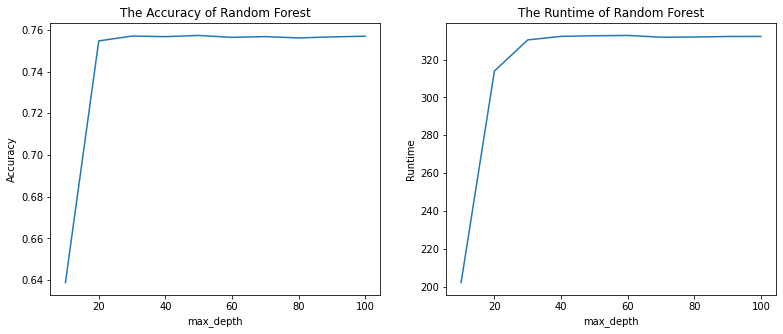

In [32]:
#Visualizations for Random Forest training result
#Graph of the accuracy vs. max_depth, the runtime vs. max_depth
title = ["The Accuracy of Random Forest", "The Runtime of Random Forest"]
x_label = ["max_depth", "max_depth"
y_label = ["Accuracy", "Runtime"]
cv_results = rf_random.cv_results_
plot_result(cv_results, title, x_label, y_label, 'max_depth')

In [24]:
print(rf_random.cv_results_)

{'mean_fit_time': array([202.33406577, 312.64495254, 328.91767397, 328.96073995,
       329.660428  , 330.1408514 , 330.15145097, 331.03753204,
       330.27580123, 332.08715453]), 'std_fit_time': array([0.56372705, 0.76256114, 0.75495402, 1.02589898, 0.23185053,
       0.68247326, 0.92473248, 1.44174524, 1.64170313, 1.15963759]), 'mean_score_time': array([0.52534461, 1.7345015 , 2.48827758, 2.49332795, 2.48086028,
       2.50343399, 2.51019702, 2.49183116, 2.48673649, 2.46457839]), 'std_score_time': array([0.00160155, 0.09574425, 0.0072807 , 0.03979533, 0.04396962,
       0.02355095, 0.00985752, 0.03385331, 0.03684181, 0.04478484]), 'param_bootstrap': masked_array(data=[False, False, False, False, False, False, False, False,
                   False, False],
             mask=[False, False, False, False, False, False, False, False,
                   False, False],
       fill_value='?',
            dtype=object), 'param_max_depth': masked_array(data=[10, 20, 30, 40, 50, 60, 70, 80, 9

In [26]:
new_grid = {k: [v] for k, v in best_params.items()}
new_grid['n_estimators'] = list(range(50, 250, 20))
print(new_grid)
rf = RandomForestClassifier()
grid_search = GridSearchCV(estimator = rf, param_grid = new_grid, cv = 5, verbose=10)
grid_search.fit(data_train, label_train)

{'n_estimators': [50, 70, 90, 110, 130, 150, 170, 190, 210, 230], 'min_samples_split': [2], 'min_samples_leaf': [1], 'max_features': ['auto'], 'max_depth': [110], 'bootstrap': [False]}
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5; 1/10] START bootstrap=False, max_depth=110, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50
[CV 1/5; 1/10] END bootstrap=False, max_depth=110, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.733 total time= 1.2min
[CV 2/5; 1/10] START bootstrap=False, max_depth=110, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50
[CV 2/5; 1/10] END bootstrap=False, max_depth=110, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.735 total time= 1.2min
[CV 3/5; 1/10] START bootstrap=False, max_depth=110, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50
[CV 3/5; 1/10] END bootstrap=False, max_depth=1

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'bootstrap': [False], 'max_depth': [110],
                         'max_features': ['auto'], 'min_samples_leaf': [1],
                         'min_samples_split': [2],
                         'n_estimators': [50, 70, 90, 110, 130, 150, 170, 190,
                                          210, 230]},
             verbose=10)

In [27]:
grid_search.cv_results_

{'mean_fit_time': array([ 72.3681623 , 101.11327324, 129.90426888, 159.34791288,
        188.18643961, 216.88711424, 246.00093136, 274.68320332,
        303.99210105, 333.82436976]),
 'std_fit_time': array([0.46534338, 0.37934914, 0.26098525, 0.37294882, 0.16138298,
        0.65261773, 0.70350817, 0.72842871, 0.45431816, 0.88843307]),
 'mean_score_time': array([0.28587465, 0.45116262, 0.66638412, 0.83311801, 1.04197478,
        1.19492078, 1.58325353, 2.06611991, 2.34407058, 2.57768245]),
 'std_score_time': array([0.01315074, 0.03801214, 0.02629902, 0.01505551, 0.04267864,
        0.00562566, 0.1382072 , 0.02362618, 0.0187399 , 0.03103009]),
 'param_bootstrap': masked_array(data=[False, False, False, False, False, False, False, False,
                    False, False],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'param_max_depth': masked_array(data=[110, 110, 110, 110

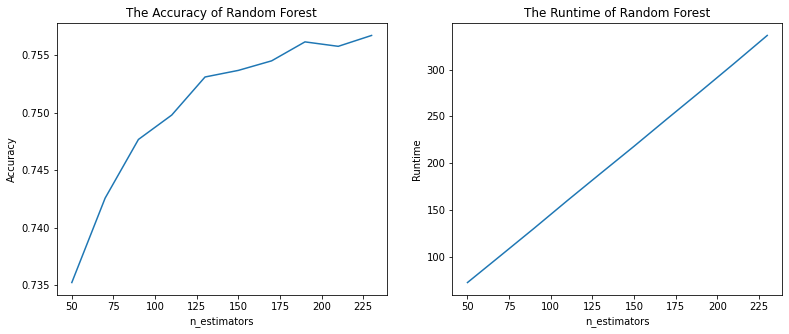

In [28]:
#Visualizations for Random Forest training result
#Graph of the accuracy vs. n_estimators, the runtime vs. n_estimators
cv_results = grid_search.cv_results_
title = ["The Accuracy of Random Forest", "The Runtime of Random Forest"]
x_label = ["n_estimators", "n_estimators"]
y_label = ["Accuracy", "Runtime"]
plot_result(cv_results, title, x_label, y_label, 'n_estimators')

In [34]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

best_esemble = RandomForestClassifier(**best_params)
best_esemble.fit(data_train, label_train)

RandomForestClassifier(bootstrap=False, max_depth=110, n_estimators=228)

In [ ]:
#calculate the perfermance metric of RF model, including precision, recall, accuracy

In [41]:
predict_data = best_esemble.predict(data_test)
precision = precision_score(label_test, predict_data, average = 'macro')
recall = recall_score(label_test, predict_data,average = 'macro')
accuracy = accuracy_score(label_test,predict_data)

print(predict_data)
print(label_test)

print("Accuracy: " + str(accuracy))
print("Recall: " + str(recall))
print("Precision: " + str(precision))

#show the confusion_matrix of this RF model
print(confusion_matrix(predict_data,label_test)[-1])

[ 5  0  2 ...  3 10  8]
[16  0  2 ...  3  0  8]
Accuracy: 0.7479367262723521
Recall: 0.48252830659431034
Precision: 0.6465831609757513
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 9]


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [43]:
#save the model

In [44]:
import joblib
joblib.dump(best_esemble,'./EMNIST./zip/matlab/random_forest.model')
best_esemble = joblib.load('./EMNIST./zip/matlab/random_forest.model')